<a href="https://colab.research.google.com/github/DahaKot/Deep-Weight-Prior/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)
    
class Conv_Net(nn.Module):
    def __init__(self, seq, clf):
        super(Conv_Net, self).__init__()
        self.seq = seq
        self.clf = clf
        
    def forward(self, x):
        return self.clf(self.seq(x)) 

def build_new_net():
    #architecture of the network copied from the article
    seq = nn.Sequential(
        nn.Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        Flatten()
    )
    clf = nn.Linear(in_features=4608, out_features=10, bias=True)
    return seq, clf

In [0]:
#copied numbers from the article
N_EPOCHS = 300
Z_DIM = 2
STAT_STEP = 100
BATCH_SIZE = 128

device = 'cpu'

In [4]:
#read data
PATH = './Learned models/models_notMNIST/model_'
weights_paths = []
learned_models = []
for i in range(100):
    #reaally not effective
    seq, clf = build_new_net()
    model = Conv_Net(seq, clf)
    weights_paths.append(PATH + str(i) + '.pt')
    
    model.load_state_dict(torch.load(weights_paths[i], map_location = 'cpu'))
    learned_models.append(model)

FileNotFoundError: ignored

In [0]:
weights = []
for model in learned_models:
    weights.append(model.seq)
    
print(weights[0])

In [0]:
weights[0][0].weight.size()
for i in range(len(weights)):
    weights[i] = weights[i][0].weight

In [5]:
#train_loader = DataLoader(dataset=weights, batch_size=BATCH_SIZE, shuffle=True) 
DATA_PATH = './trueMNIST'
trans = tt.Compose([tt.ToTensor(), tt.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  transform=trans, download=True) 

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 9790762.29it/s]                            


Extracting ./trueMNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 132366.92it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./trueMNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2240614.74it/s]                            
0it [00:00, ?it/s]

Extracting ./trueMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49565.56it/s]            


Extracting ./trueMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
#cuda!
#test on colab at least one iteration
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False)
              
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
                
        normal = Normal(mu_x, torch.sqrt(var_x))
        diagn = torch.distributions.Independent(normal, 1)
         
        #count loss
        latent_loss = 0.5 * torch.sum(var_x + mu_x**2 - torch.log(var_x) - 1)
        reconstruction_loss = diagn.log_prob(X)
        
        #coefs are to be chosen
#         if (i % 50 == 0):
#             print(i)
#             print("KL: ", latent_loss.item())
#             print("L2: ", reconstruction_loss[0][0])
#             print("mu_mean: ", torch.mean(torch.abs(mu_x)))
        return -(torch.sum(reconstruction_loss) - latent_loss), latent_loss, torch.sum(reconstruction_loss)
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d]))
        return self.decoder(z)

In [0]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0),
#             nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0)
            nn.Linear(self.D, 200),
            nn.LeakyReLU()
        )
        
#         self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
#         self.fc_var = nn.Sequential(
#             nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
#             nn.Softplus()
#         )
        self.fc_mu = nn.Linear(200, self.d)
        self.fc_var = nn.Sequential(
            nn.Linear(200, self.d),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [0]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
#             nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0),
#             nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0),
#             nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
#             nn.ELU(alpha=1.0)
            nn.Linear(self.d, 200),
            nn.LeakyReLU()
        )
#         self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
#         self.fc_var = nn.Sequential(
#             nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
#             nn.Softplus()
#         )
        self.fc_mu = nn.Linear(200, self.D)
        self.fc_var = nn.Sequential(
            nn.Linear(200, self.D),
            nn.Softplus(),
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [0]:
#Adam optimizer with linear learning rate decay from 1e-3 to 0.
vae = VAE(784)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

In [10]:
loss_list = []
kl_loss_list = []
l2_loss_list = []
N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for j in range(N_EPOCHS):
    for k, (images, labels) in enumerate(train_loader):
        #forward
        images = images.view(images.size()[0], -1)
        images = images.to(device)
        vlb, kl, l2 = vae.count_vlb(images, j*N_EPOCHS + k)
#         if torch.isnan(vlb):
#             print("alarma!")
#             vlb = nn.Parameter(torch.ones(vlb.size()), requires_grad=True)

        #backward
        optimizer.zero_grad()
        vlb.backward()
        optimizer.step()

        loss_list.append(vlb.item())
        kl_loss_list.append(kl)
        l2_loss_list.append(l2)
        
        if k % STAT_STEP == 0:
            print('Epoch {}/{}, Step {}/{}, Loss: {}'
                  .format(j, N_EPOCHS, k, N_STEPS, vlb.item()))

469
Epoch 0/300, Step 0/469, Loss: 160336.890625
Epoch 0/300, Step 100/469, Loss: 119966.171875
Epoch 0/300, Step 200/469, Loss: 109875.5234375
Epoch 0/300, Step 300/469, Loss: 109297.484375
Epoch 0/300, Step 400/469, Loss: 106800.78125
Epoch 1/300, Step 0/469, Loss: 108337.03125
Epoch 1/300, Step 100/469, Loss: 108353.203125
Epoch 1/300, Step 200/469, Loss: 108550.171875
Epoch 1/300, Step 300/469, Loss: 105162.734375
Epoch 1/300, Step 400/469, Loss: 105973.1328125
Epoch 2/300, Step 0/469, Loss: 107955.609375
Epoch 2/300, Step 100/469, Loss: 107722.953125
Epoch 2/300, Step 200/469, Loss: 107178.2734375
Epoch 2/300, Step 300/469, Loss: 106908.09375
Epoch 2/300, Step 400/469, Loss: 106606.75
Epoch 3/300, Step 0/469, Loss: 105095.125
Epoch 3/300, Step 100/469, Loss: 103936.4609375
Epoch 3/300, Step 200/469, Loss: 106735.9765625
Epoch 3/300, Step 300/469, Loss: 103520.921875
Epoch 3/300, Step 400/469, Loss: 104561.34375
Epoch 4/300, Step 0/469, Loss: 104715.2734375
Epoch 4/300, Step 100/46

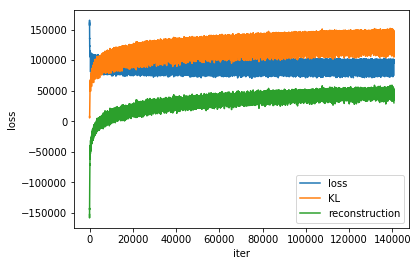

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([i for i in range(len(loss_list))], loss_list, label = 'loss')
plt.plot([i for i in range(len(loss_list))], kl_loss_list, label = 'KL')
plt.plot([i for i in range(len(loss_list))], l2_loss_list, label = 'reconstruction')

plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.show()

In [0]:
torch.save(vae.state_dict(), "vae_mnist1.pth")

In [29]:
vae.load_state_dict(torch.load("vae_mnist1.pth"))

mu_list = []

with torch.no_grad():
    for k, images in enumerate(train_loader):
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        mu, var  = vae.encoder(images)
        mu = mu.cpu().numpy()
        mu_list.append(mu)

mu = np.concatenate(mu_list)
mu = np.squeeze(mu, axis = 2)
mu = np.squeeze(mu, axis = 2)

print(mu[:, 0])

plt.figure(figsize=(12, 10))

plt.scatter(mu[:5000, 0], mu[:5000, 1], marker = '+')

plt.grid()
    

AttributeError: ignored

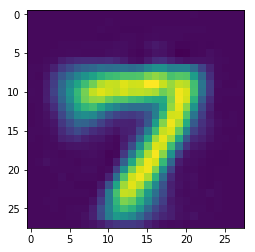

In [21]:
with torch.no_grad():
    mu_x, _ = vae.generate_samples(100)
    mu_x = mu_x.detach().cpu().numpy()
    
plt.imshow(mu_x[99].reshape((28, 28)))

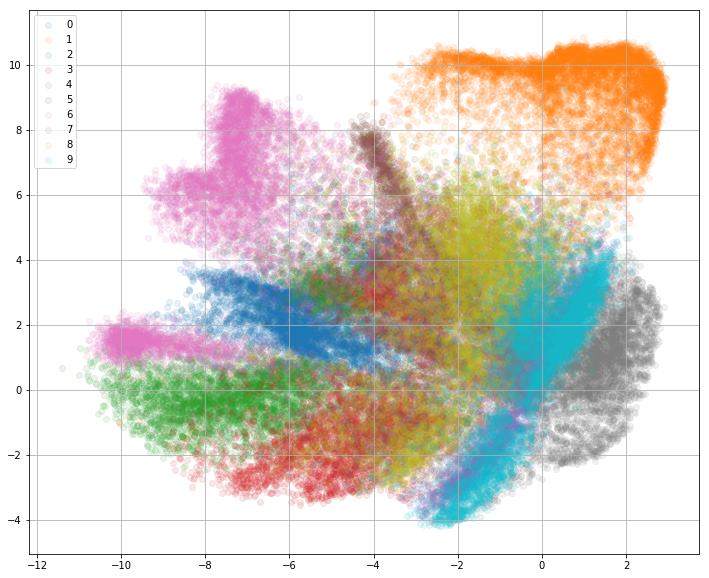

In [38]:

mu_list = []
label_list = []

with torch.no_grad():
    for k, (images, labels) in enumerate(train_loader):
        #forward
        label_list.append(labels.numpy())
        images = images.view(images.size()[0], -1)
        images = images.to(device)
        mu, sigma  = vae.encoder(images)
        mu = mu.cpu().numpy()
        mu_list.append(mu)

mu = np.concatenate(mu_list)
labels = np.concatenate(label_list)

import matplotlib.pyplot as plt
%matplotlib inline

mu.shape

plt.figure(figsize=(12, 10))
for i in range(10):
    mask = labels == i
    plt.scatter(mu[mask, 0], mu[mask,1], label=str(i), alpha=0.1)
plt.legend()
plt.grid()

tensor([-0.7500, -0.2500])


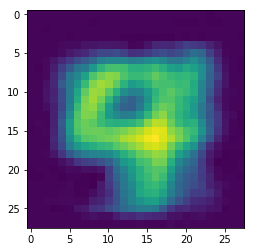

In [41]:
z = torch.FloatTensor([-0.75, -0.25])
print(z)
mu_x, _ = vae.decoder(z)
    
plt.imshow(mu_x.detach().numpy().reshape((28, 28)))

In [0]:
mu = torch.eye(3, 3)*10
mu[0, 1] = 2
mu[0, 2] = 10
mu[1, 0] = 3
mu[1, 2] = -1
mu[2, 0] = 1
mu[2, 1] = -10
mu = mu
print(mu)
sigma = torch.eye(3, 3)*2
sigma[0, 1] = 2
sigma[0, 2] = 10
sigma[1, 0] = 3
sigma[1, 2] = 100
sigma[2, 0] = 1
sigma[2, 1] = 10
print(sigma)
K = 1

In [16]:
std_z = torch.from_numpy(np.random.normal(0, 1, size=[*sigma.size(), K])).type(mu.type())
std_z = std_z.permute(0, 2, 1)
z = mu[:, None, :] + torch.sqrt(sigma[:, None, :]) * nn.Parameter(std_z, requires_grad=False)
print(z)
print(z.mean())
print(z.std())

z = Normal(torch.zeros(3, 3), torch.ones(3, 3)).sample()
z = mu + torch.sqrt(sigma) * z
print(z)
print(z.mean())
print(z.std())

NameError: ignored